<a href="https://colab.research.google.com/github/AyberkMunis/AFIB_Classification_Project/blob/main/AFIB_Classification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AFIB Classification Project**

### Project Description

* This project aims classifying AFIB disease by using patient's ECG records.
* ECG (Electrocardiogram) is records of electrical signal from heart to check patient's heart conditions.
* This project uses PTB XL database from kaggle (https://www.kaggle.com/datasets/khyeh0719/ptb-xl-dataset). It includes 21,187 patient's ECG and personal data
* 1-Dimensional Convolutional Neural Networks are used as models in this project


## Steps of Project
1. Importing Libraries and Data
2. Preparing data for the model
3. Modeling with all data
4. Modeling with undersampling
5. Modeling with loops of undersampling

## 0. Needed Functions

In [1]:
def importclassAFIB(col):
  """
  This functions returns 1 if the patient diagnoses with AFIB. You must use with apply method of dataframe's scp_codes column.
  col: column of dataframe
  """
  if "AFIB" in col :
    return 1
  else:
    return 0

In [2]:
main_path="/content/ptb-xl-dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/"
def preparedata(df,length_dataframe):
  """
  This function converts raw ECG data to numpy array and classifies it. It returns X and y sets for the model.
  df: main data frame which keeps the path of ECG files
  length_dataframe: range from 0 to length of data frame
  """
  X=[]
  y=[]
  for i in list(length_dataframe):
    path=df.iloc[i]["filename_lr"]
    path=main_path+path
    record=wfdb.rdsamp(path)[0]
    clasdata=df.iloc[i]["target"]
    X.append(record)
    y.append(clasdata)
  return (np.array(X),np.array(y))


In [3]:
def scale(data,scaler):
  """
  data:numpy array
  scaler: scaler object like MinMaxScaler
  This function rescales numeric data with given scaler
  """
  for i in range(0,len(data)):
    data[i]=scaler.fit_transform(data[i])
  return data

In [4]:
def plot_histo(history):
  """
  history:history obejct of model
  This function gives learning rate vs loss plot to determine the learning rate
  """

  lfs=1e-4 * 10 ** (tf.range(0,50)/20)
  plt.plot(lfs,history.history["loss"][:50])
  plt.title("Learnin Rate vs Loss")
  plt.xlabel("Learning Rate")
  plt.ylabel("Loss")
  plt.show()

In [49]:
def metrics(model,true,test):
  """
  model: your model
  true:  true labels of your test set
  test: your test set
  This function calculates important accuracy,recall,f1,precision,roc_auc score metrics of your model for the test set
  returns: accuracy,recall,f1,prec,roc_auc
  """
  pred=model.predict(test)
  roc_auc=roc_auc_score(true,pred)
  pred=[round(x[0]) for x in pred]
  recall=recall_score(true,pred)
  f1=f1_score(true,pred)
  prec=precision_score(true,pred)
  accuracy=accuracy_score(true,pred)

  print(f"accuracy:{float(accuracy)},f1:{float(f1)} recall:{float(recall)} precision:{float(prec)}, roc_auc:{float(roc_auc)}")
  return accuracy,recall,f1,prec,roc_auc

In [37]:
def confusionmatrix(y_test,pred):
  """
  y_test: your test labels
  pred:your model's predictions
  This function plots confusion matrix of your model
  """
  pred=[round(x[0]) for x in pred]
  mat=confusion_matrix(y_test,pred)
  disp=ConfusionMatrixDisplay(mat)
  disp.plot()
  plt.show()
  return disp

In [39]:
def undersample(X,y):
  """
  X: your feature class
  y: your label class
  This function produces new X and y class which has balanced data
  """
  true_labels=[]

  for k,i in zip(range(0,len(y)),y):
    if i==1:
      true_labels.append(k)
  count=0
  zero_labels=[]
  while True:
    if count==len(true_labels):
      break
    else:
      num=int(np.random.uniform(0,len(y)))
      if y[num]==0 and num not in zero_labels:
        zero_labels.append(num)
        count+=1
  all_labels=[]
  all_labels.extend(true_labels)
  all_labels.extend(zero_labels)
  X_undersam=[X[l] for l in all_labels]
  y_undersam=[y[l] for l in all_labels]
  X_undersam=np.array(X_undersam)
  y_undersam=np.array(y_undersam)
  return X_undersam,y_undersam

In [75]:
def undersamplewithloop(model,x,y,epchno):
  """
  model:your model
  x: your feature set
  y:  your label set
  epochno: how many epochs you want
  This function does under sampling with loop. It trains the model with small subsets of data which is randomly picked at every iteration.
  """
  all_label=[]
  true_labels=[]
  all=[]
  samp=floor(len(x)/epchno)
  count1=0
  countm=1
  count2=0
  zero_labels=[]
  pred=""
  while True:
    if countm==floor(1514/samp):
      break
    while True:
      if count1==samp:
        break
      else:
        num=int(np.random.uniform(0,len(y)))
        if y[num]==1 and num not in true_labels and num not in all_label:
          true_labels.append(num)
          all_label.append(num)
          count1+=1
    while True:
      if count2==samp:
        break
      else:
        num=int(np.random.uniform(0,len(y)))
        if y[num]==0 and num not in true_labels and num not in all_label:
          zero_labels.append(num)
          all_label.append(num)
          count2+=1
    all.extend(true_labels)
    all.extend(zero_labels)
    x_new=[x[l] for l in all]
    y_new=[y[l] for l in all]
    x_new=np.array(x_new)
    y_new=np.array(y_new)
    X_train,X_test,y_train,y_test=train_test_split(x_new,y_new,test_size=0.2,random_state=42)
    histo=model.fit(X_train,y_train,epochs=50,validation_data=(X_test,y_test))
    true_labels=[]
    zero_labels=[]
    countm+=1
    accuracy,recall,f1,prec,roc_auc=metrics(model,y_test,X_test)
    pred=model.predict(X_test)
  return  accuracy,recall,f1,prec,roc_auc,pred,y_test


# 1. Importing Libraries and Data

In [6]:
!pip install opendatasets
!pip install wfdb


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 3.3 MB/s eta 0:00:00


In [73]:
#Importing Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import wfdb
import opendatasets as od
from sklearn.model_selection import train_test_split
import ast
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from keras.utils import plot_model
from math import floor


In [8]:
#Downloading the data
od.download("https://www.kaggle.com/datasets/khyeh0719/ptb-xl-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ayberkmunis
Your Kaggle Key: ··········


100%|██████████| 1.72G/1.72G [00:58<00:00, 31.7MB/s]


In [9]:
#Importing ptbxl_database
Y = pd.read_csv('/content/ptb-xl-dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/ptbxl_database.csv')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

In [10]:
Y.head()

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


## 2. Data Preprocessing

In [11]:
# Creating a target column for the model. If patient has AFIB, column has 1, else 0
Y["target"]=Y["scp_codes"].apply(importclassAFIB)

In [12]:
# There are 1514 patient who diagnoses with AFIB
Y.groupby("target").agg({"target":"count"})

,target
target,
0,20323
1,1514


In [13]:
#This function prepares our  two main datasets, X which has the features (ECG measurements), y which has the labels
X,y=preparedata(Y,range(0,len(Y)))

In [14]:
#Example ECG data and its label
X[0],y[0]

(array([[-0.119, -0.055,  0.064, ..., -0.026, -0.039, -0.079],
        [-0.116, -0.051,  0.065, ..., -0.031, -0.034, -0.074],
        [-0.12 , -0.044,  0.076, ..., -0.028, -0.029, -0.069],
        ...,
        [ 0.069,  0.   , -0.069, ...,  0.024, -0.041, -0.058],
        [ 0.086,  0.004, -0.081, ...,  0.242, -0.046, -0.098],
        [ 0.022, -0.031, -0.054, ...,  0.143, -0.035, -0.12 ]]),
 0)

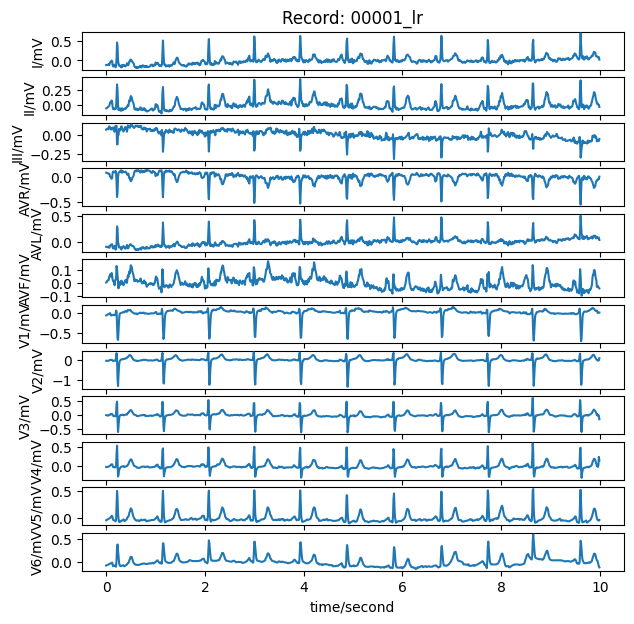

In [15]:
#Visualizing ECG measurements
samprecord=wfdb.io.rdrecord(main_path+Y.iloc[0]["filename_lr"])
wfdb.plot_wfdb(samprecord,figsize=(7,7))

In [16]:
#Scaling the data by using MinMaxScaler
X=scale(X,MinMaxScaler())

In [17]:
#Splitting our data into train and test sets
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)


## 3. Modelling with all data

In [18]:
#Our very first base model using 1-D CNN
tf.random.set_seed(42)
model_001=tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(1000,12)),
    tf.keras.layers.Conv1D(32,3,activation="relu"),
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Conv1D(64,3,activation="relu"),
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Conv1D(128,3,activation="relu"),
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Conv1D(256,3,activation="relu"),
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1,activation="sigmoid")



])
lr=tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10 ** (epoch/20))
model_001.compile(loss=tf.keras.losses.binary_crossentropy,optimizer=tf.keras.optimizers.SGD(),metrics=["accuracy"])

In [19]:
model_001.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 998, 32)           1184      
                                                                 
 max_pooling1d (MaxPooling1  (None, 499, 32)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 497, 64)           6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 248, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 246, 128)          24704     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 123, 128)          0

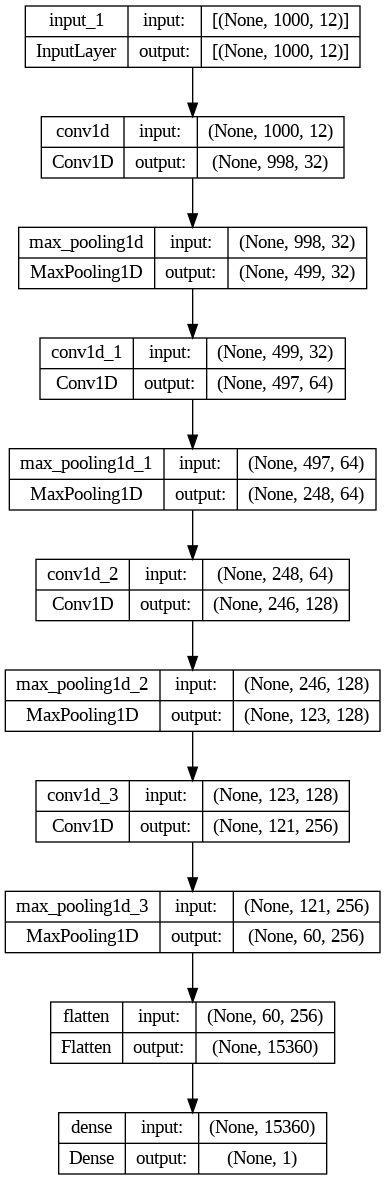

In [20]:
plot_model(model_001,show_shapes=True)

In [21]:
history_01=model_001.fit(X_train,y_train,epochs=50,callbacks=[lr],validation_data=(X_test,y_test))

Epoch 1/50
546/546 [==============================] - 15s 8ms/step - loss: 0.5595 - accuracy: 0.8882 - val_loss: 0.4333 - val_accuracy: 0.9297 - lr: 1.0000e-04
Epoch 2/50
546/546 [==============================] - 3s 6ms/step - loss: 0.3464 - accuracy: 0.9309 - val_loss: 0.2914 - val_accuracy: 0.9297 - lr: 1.1220e-04
Epoch 3/50
546/546 [==============================] - 3s 6ms/step - loss: 0.2692 - accuracy: 0.9309 - val_loss: 0.2616 - val_accuracy: 0.9297 - lr: 1.2589e-04
Epoch 4/50
546/546 [==============================] - 3s 6ms/step - loss: 0.2562 - accuracy: 0.9309 - val_loss: 0.2581 - val_accuracy: 0.9297 - lr: 1.4125e-04
Epoch 5/50
546/546 [==============================] - 3s 6ms/step - loss: 0.2543 - accuracy: 0.9309 - val_loss: 0.2575 - val_accuracy: 0.9297 - lr: 1.5849e-04
Epoch 6/50
546/546 [==============================] - 3s 6ms/step - loss: 0.2538 - accuracy: 0.9309 - val_loss: 0.2571 - val_accuracy: 0.9297 - lr: 1.7783e-04
Epoch 7/50
546/546 [=========================

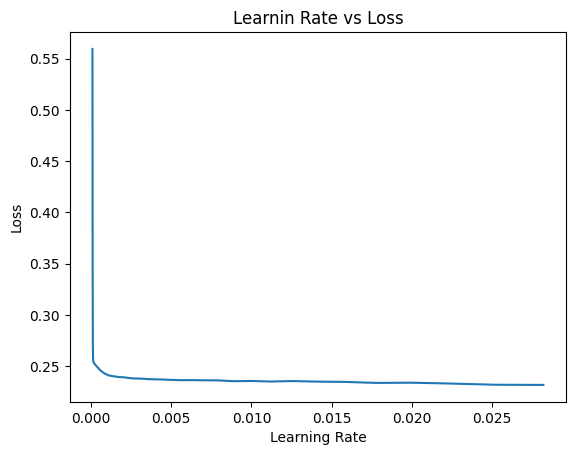

In [22]:
#Plotting learning rate vs loss graph to determine optimum learning rate
plot_histo(history_01)

In [27]:
#Set our model again with 0.0282 learning rate
model_002=tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(1000,12)),
    tf.keras.layers.Conv1D(32,3,activation="relu"),
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Conv1D(64,3,activation="relu"),
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Conv1D(128,3,activation="relu"),
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Conv1D(256,3,activation="relu"),
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1,activation="sigmoid")



])
model_002.compile(loss=tf.keras.losses.binary_crossentropy,optimizer=tf.keras.optimizers.SGD(learning_rate=0.0282),metrics=["accuracy"])

In [28]:
# We will increase epoch number to 150 for better learning
history_02=model_002.fit(X_train,y_train,epochs=150,validation_data=(X_test,y_test))

Epoch 1/150
546/546 [==============================] - 5s 8ms/step - loss: 0.2521 - accuracy: 0.9295 - val_loss: 0.2453 - val_accuracy: 0.9297
Epoch 2/150
546/546 [==============================] - 3s 6ms/step - loss: 0.2411 - accuracy: 0.9309 - val_loss: 0.2481 - val_accuracy: 0.9297
Epoch 3/150
546/546 [==============================] - 3s 6ms/step - loss: 0.2387 - accuracy: 0.9309 - val_loss: 0.2432 - val_accuracy: 0.9297
Epoch 4/150
546/546 [==============================] - 3s 6ms/step - loss: 0.2375 - accuracy: 0.9309 - val_loss: 0.2421 - val_accuracy: 0.9297
Epoch 5/150
546/546 [==============================] - 3s 6ms/step - loss: 0.2370 - accuracy: 0.9309 - val_loss: 0.2450 - val_accuracy: 0.9297
Epoch 6/150
546/546 [==============================] - 3s 6ms/step - loss: 0.2361 - accuracy: 0.9309 - val_loss: 0.2434 - val_accuracy: 0.9297
Epoch 7/150
546/546 [==============================] - 3s 6ms/step - loss: 0.2344 - accuracy: 0.9309 - val_loss: 0.2456 - val_accuracy: 0.9297

In [32]:
#Printing metrics of our first model
accuracy01,recall01,f101,prec01,roc_auc01=metrics(model_002,y_test,X_test)

137/137 [==============================] - 0s 3ms/step
accuracy:0.9590201465201466,f1:0.6919104991394147 recall:0.6547231270358306 precision:0.7335766423357665, roc_auc:0.9639604340003864


In [107]:
#Getting predictions of our model
pred_01=model_002.predict(X_test)
pred_01=[round(x[0]) for x in pred_01]

137/137 [==============================] - 0s 3ms/step


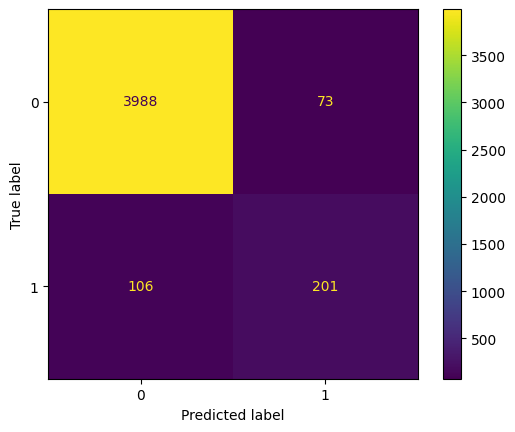

In [38]:
#Plotting our first model's confusion matrix
conf01=confusionmatrix(y_test,pred_01)

## 3. Modeling with Undersampling

Because of unbalanced data, sometimes developing the classification model could be hard. The reason why we will create a new data set from our data set which contains equal number of samples that have AFIB or not. This process is called "Undersampling".

In [40]:
#Undersampling our data
X_under,y_under=undersample(X,y)

In [41]:
pd.DataFrame(y_under).groupby(0).agg({0:"count"})
#This Data Frame shows we have equal 0 and 1 class which was our goal

,0
0,
0,1514
1,1514


In [63]:
#Splitting our new data sets into train and test data
Xu_train,Xu_test,yu_train,yu_test=train_test_split(X_under,y_under,test_size=0.2,random_state=42)

In [64]:
#Th,s is our new model for undersampled data
#A new convolutional layer is added and filter numbers are changed
#Learning rate is same as above
model_003=tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(1000,12)),
    tf.keras.layers.Conv1D(64,3,activation="relu"),
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Conv1D(128,3,activation="relu"),
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Conv1D(256,3,activation="relu"),
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Conv1D(512,3,activation="relu"),
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Conv1D(512,3,activation="relu"),
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1,activation="sigmoid")



])
model_003.compile(loss=tf.keras.losses.binary_crossentropy,optimizer=tf.keras.optimizers.SGD(learning_rate=0.0282),metrics=["accuracy"])

In [65]:
model_003.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_26 (Conv1D)          (None, 998, 64)           2368      
                                                                 
 max_pooling1d_26 (MaxPooli  (None, 499, 64)           0         
 ng1D)                                                           
                                                                 
 conv1d_27 (Conv1D)          (None, 497, 128)          24704     
                                                                 
 max_pooling1d_27 (MaxPooli  (None, 248, 128)          0         
 ng1D)                                                           
                                                                 
 conv1d_28 (Conv1D)          (None, 246, 256)          98560     
                                                                 
 max_pooling1d_28 (MaxPooli  (None, 123, 256)         

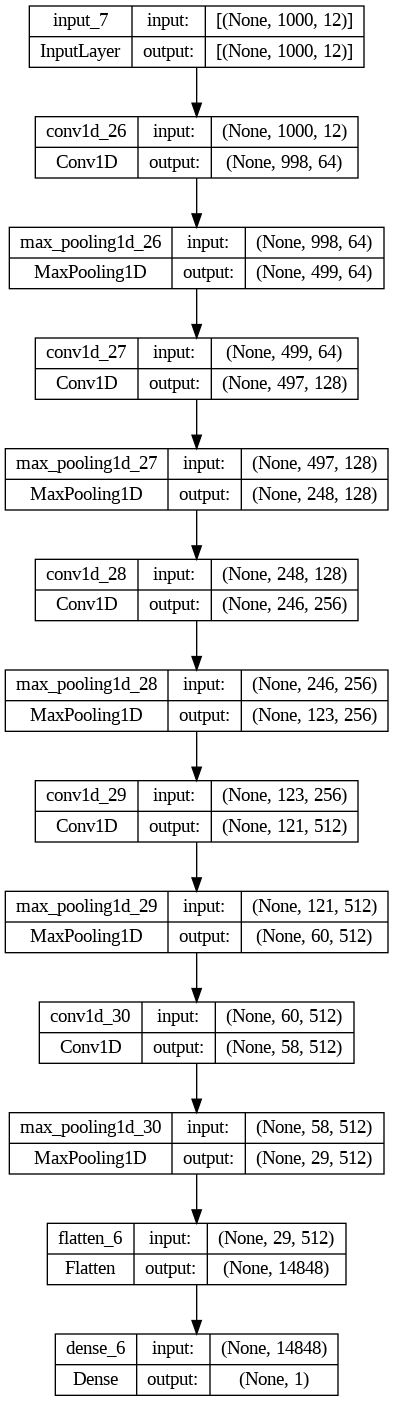

In [66]:
plot_model(model_003,show_shapes=True)

In [67]:
#Train our new model
history_03=model_003.fit(Xu_train,yu_train,epochs=150,validation_data=(Xu_test,yu_test))

Epoch 1/150
76/76 [==============================] - 3s 25ms/step - loss: 0.6886 - accuracy: 0.5475 - val_loss: 0.6793 - val_accuracy: 0.6172
Epoch 2/150
76/76 [==============================] - 1s 16ms/step - loss: 0.6702 - accuracy: 0.6082 - val_loss: 0.6822 - val_accuracy: 0.5677
Epoch 3/150
76/76 [==============================] - 1s 16ms/step - loss: 0.6573 - accuracy: 0.6197 - val_loss: 0.6581 - val_accuracy: 0.5825
Epoch 4/150
76/76 [==============================] - 1s 16ms/step - loss: 0.6418 - accuracy: 0.6346 - val_loss: 0.6730 - val_accuracy: 0.5660
Epoch 5/150
76/76 [==============================] - 1s 16ms/step - loss: 0.6423 - accuracy: 0.6350 - val_loss: 0.6344 - val_accuracy: 0.6370
Epoch 6/150
76/76 [==============================] - 1s 16ms/step - loss: 0.6352 - accuracy: 0.6524 - val_loss: 0.6382 - val_accuracy: 0.6584
Epoch 7/150
76/76 [==============================] - 1s 16ms/step - loss: 0.6288 - accuracy: 0.6511 - val_loss: 0.6367 - val_accuracy: 0.6518
Epoch 

In [68]:
accuracy02,recall02,f102,prec02,roc_auc02=metrics(model_003,yu_test,Xu_test)

19/19 [==============================] - 0s 7ms/step
accuracy:0.933993399339934,f1:0.9376947040498442 recall:0.9465408805031447 precision:0.9290123456790124, roc_auc:0.9669975104821803


In [108]:
pred_02=model_003.predict(Xu_test)
pred_02=[round(x[0]) for x in pred_02]

19/19 [==============================] - 0s 7ms/step


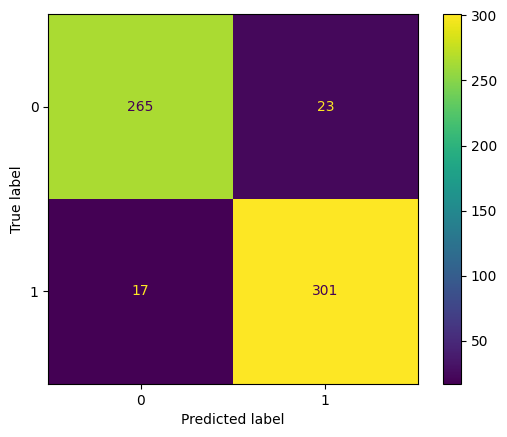

In [70]:
conf2=confusionmatrix(yu_test,pred02)

## 4.Undersampling with Looping

In this section, we will sample the data by using loops. Generally, we will train the model with different data sets which is randomly selected at every iteration of the loop between our undersampled data. The loop ends when the model sees all of the data whose label is 1.The loop follows these steps:
1. Entering an epoch
2. Length of data is divided by epoch number (we call samp)
3. The number of data which equals to samp are sampled.
4. The model is trained by 50 epochs
5. Repeat this until sample * number of loops >= number of data who has AFIB

In [83]:
model_004=tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(1000,12)),
    tf.keras.layers.Conv1D(64,3,activation="relu"),
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Conv1D(128,3,activation="relu"),
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Conv1D(256,3,activation="relu"),
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Conv1D(512,3,activation="relu"),
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Conv1D(512,3,activation="relu"),
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1,activation="sigmoid")



])
model_004.compile(loss=tf.keras.losses.binary_crossentropy,optimizer=tf.keras.optimizers.SGD(learning_rate=0.0282),metrics=["accuracy"])

In [84]:
accuracy03,recall03,f103,prec03,roc_auc03,pred03,y_test03=undersamplewithloop(model_004,X_under,y_under,50)

Epoch 1/50
3/3 [==============================] - 1s 136ms/step - loss: 0.6946 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5833
Epoch 2/50
3/3 [==============================] - 0s 38ms/step - loss: 0.6990 - accuracy: 0.5000 - val_loss: 0.6895 - val_accuracy: 0.5417
Epoch 3/50
3/3 [==============================] - 0s 38ms/step - loss: 0.6944 - accuracy: 0.4688 - val_loss: 0.6916 - val_accuracy: 0.6250
Epoch 4/50
3/3 [==============================] - 0s 32ms/step - loss: 0.6930 - accuracy: 0.6042 - val_loss: 0.6938 - val_accuracy: 0.4583
Epoch 5/50
3/3 [==============================] - 0s 32ms/step - loss: 0.6909 - accuracy: 0.5104 - val_loss: 0.6918 - val_accuracy: 0.5833
Epoch 6/50
3/3 [==============================] - 0s 32ms/step - loss: 0.6908 - accuracy: 0.5312 - val_loss: 0.6924 - val_accuracy: 0.4583
Epoch 7/50
3/3 [==============================] - 0s 29ms/step - loss: 0.6927 - accuracy: 0.4792 - val_loss: 0.6927 - val_accuracy: 0.4583
Epoch 8/50
3/3 [==========

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 45ms/step - loss: 0.6964 - accuracy: 0.6458 - val_loss: 0.6800 - val_accuracy: 0.6250
Epoch 2/50
3/3 [==============================] - 0s 27ms/step - loss: 0.4209 - accuracy: 0.8542 - val_loss: 0.7176 - val_accuracy: 0.6250
Epoch 3/50
3/3 [==============================] - 0s 29ms/step - loss: 0.4264 - accuracy: 0.7812 - val_loss: 0.6836 - val_accuracy: 0.6250
Epoch 4/50
3/3 [==============================] - 0s 27ms/step - loss: 0.3867 - accuracy: 0.8125 - val_loss: 0.7299 - val_accuracy: 0.5833
Epoch 5/50
3/3 [==============================] - 0s 27ms/step - loss: 0.3815 - accuracy: 0.8438 - val_loss: 0.7661 - val_accuracy: 0.4583
Epoch 6/50
3/3 [==============================] - 0s 27ms/step - loss: 0.5132 - accuracy: 0.7292 - val_loss: 0.7226 - val_accuracy: 0.5833
Epoch 7/50
3/3 [==============================] - 0s 28ms/step - loss: 0.4331 - accuracy: 0.8333 - val_loss: 0.6810 - val_accuracy: 0.6667
Epoch 8/50
3/3 [======================

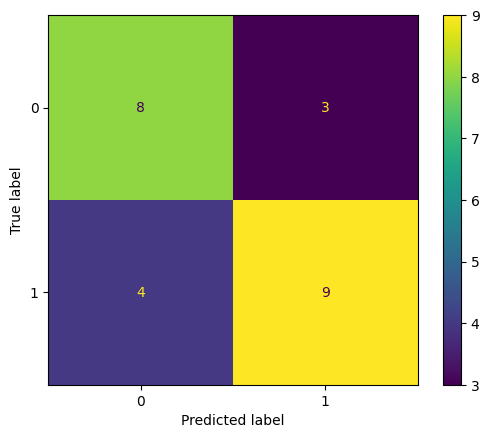

In [86]:
#Last test set's confusion matrix

conf3=confusionmatrix(y_test03,pred03)

In [111]:

pred_03=[round(x[0]) for x in pred03]

## 5. Comparing All Models

In [87]:
scores={"Accuracy":[accuracy01,accuracy02,accuracy03],"Precision":[prec01,prec02,prec03],"F1_score":[f101,f102,f103],"Recall":[recall01,recall02,recall03],"Roc_Auc":[roc_auc01,roc_auc02,roc_auc03]}

In [89]:
df=pd.DataFrame(scores,index=["Normal Model","Doing Undersampling","Doing Undersampling with Loop"])
df

,Accuracy,Precision,F1_score,Recall,Roc_Auc
Normal Model,0.959020,0.733577,0.691910,0.654723,0.963960
Doing Undersampling,0.933993,0.929012,0.937695,0.946541,0.966998
Doing Undersampling with Loop,0.708333,0.750000,0.720000,0.692308,0.699301


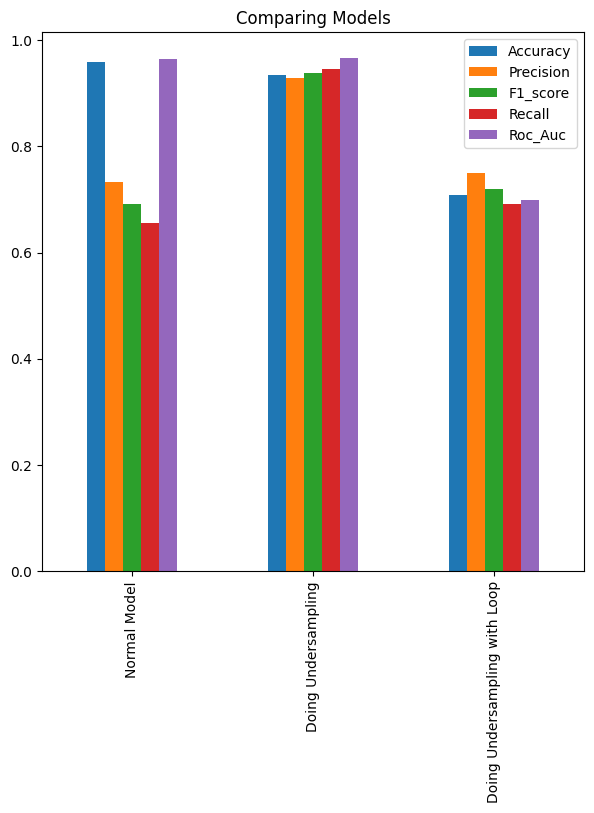

In [90]:
fig=df.plot(kind="bar",figsize=(7,7),title="Comparing Models")
plt.show()

Text(0.5, 0.98, 'Heat Maps of Three models')

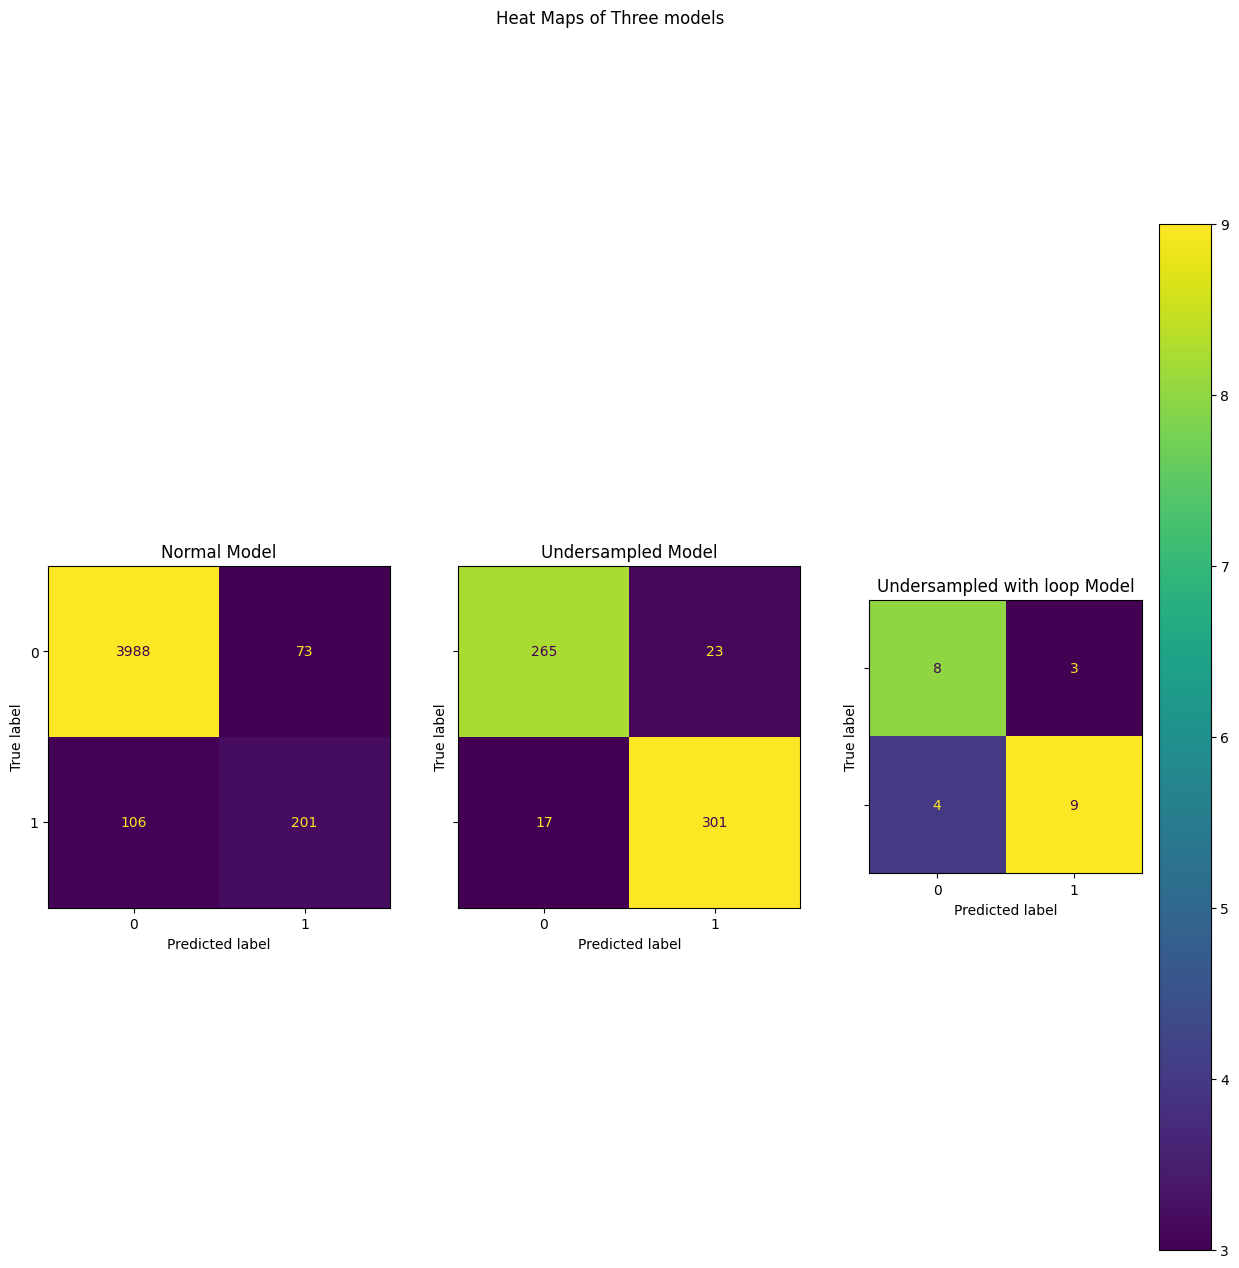

In [138]:
fig,ax=plt.subplots(1,3,sharey=True,figsize=(15,15))
ax[0].title.set_text("Normal Model")
ax[1].title.set_text("Undersampled Model")
ax[2].title.set_text("Undersampled with loop Model")
conf01.plot(ax=ax[0],colorbar=False)
conf2.plot(ax=ax[1],colorbar=False)
conf3.plot(ax=ax[2])
fig.suptitle("Heat Maps of Three models")

# 6. Conclusion

The model which is trained by normal undersampling ,which has >%90 score at all metrics,seems the best model between three models. On the other hand, despite normal model having larger accuracy, it is not a suitable model for this problem because it is not good at classifying who diagnoses with the AFIB, so it could raise problems by diagnosing a patient who does not have AFIB. Furthermore, the model which is using undersampling with loop is overfitted. The reason behind it is all of the subsets are very small ,so the model performs incredibely good at training steps, but not at test set. I will add pre-trained model to the repisotary.